Once the data is clean, we follow by developing a machine learning-based algorithm for LBSs prediction. 

In [1]:
# to handle datasets
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for machine learning
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# for evaluation 
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, roc_curve, roc_auc_score

# for saving
import joblib

In [2]:
# load data
data = pd.read_csv("cleaned_dataset.csv", delimiter = ',')

In [3]:
data.head()

,hydrophobicity,polarity,positive,negative,isoelectric point,secondary structure,sasa,A,R,N,...,M,F,P,S,T,W,Y,V,entropy,activity
0,-4.2,-0.41,0.0,0.0,5.97,0,182.08,0,-3,-1,...,-3,-4,-2,1,-1,-3,-3,-3,184.06,0
1,-4.2,-0.41,0.0,0.0,5.97,0,182.90,0,-3,-1,...,-3,-4,-3,-1,-2,-3,-4,-4,200.00,0
2,38.5,-0.80,0.0,1.0,2.77,0,258.68,-2,-2,1,...,-3,-3,-2,-1,-2,-4,-1,-4,175.11,0
3,-10.9,1.09,0.0,0.0,5.96,2,250.54,-1,-3,-3,...,0,-1,-3,-2,0,-3,-2,5,200.00,0
4,-10.9,1.09,0.0,0.0,5.96,2,241.66,-1,-3,-4,...,1,-1,-3,-2,-1,-3,-1,4,170.77,0


**1. Define the responsive (i.e. activity) and explanatory variables**

In [4]:
y = data.iloc[:,-1]
x = data.iloc[:,0:-1]

**2. Split the data**

We split the original data into three sets: the training, the validation and the testing. The training set will be used to train all models. Sometimes, it will need to be scaled. Then, the validation set will be used to assess the quality of the model prediction, using several metrics such as the precision among others, once the classifier is trained. Finally, once we have chosen the better-performing model, we will use the testing set to assess the quality of the model prediction but now only with the selected model.

In [5]:
# Split the n observations into the training, validation and test sets using the 80:20 proportion
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train, train_size=0.8, test_size=0.2, random_state=42)

We split the data in order that the **test data represents a 20% and the training a 80%**. The ratio of the split can vary depending on the size of the dataset and the complexity of the model. However, a 80/20 split is a common practice in many machine learning applications. The 80% is used to train the model, and the 20% is used to evaluate the model's performance. We chose that ratio because by reserving 80% of the data for training, we have enough data to train the model effectively. If we allocate too much data for testing, we may not have enough data to train the model correctly. In the same way, by using 20% of the data for testing, we can reliably evaluate the performance of the model. If we allocate too little data for testing, the evaluation may not be representative of the model's true performance. Moreover, by reserving a significant portion of the data for testing, we can prevent overfitting. Overfitting occurs when a model is trained on the training data so well that it becomes too specialized to the training data and performs poorly on new data. By testing the model on a separate set of data, we can ensure that the model has not overfit to the training data.

**3. Feature selection**

For the feature selection step we analyse the correlation between each pair of columns of the dataframe as well as the correlation between each feature and the 'activity' variable.

In [6]:
# Analyse the data correlation finding the pairwise correlation of all columns 
# in the dataframe with the 'activity' column, and get the corresponding values in 
# descending order
training_data = pd.concat([y_train, x_train], axis=1)
corr = training_data.corr(method = 'spearman')
corr_ordered = corr.nlargest(30,'activity')['activity']

print (corr_ordered)

activity               1.000000
entropy                0.137151
sasa                   0.049606
positive               0.025942
polarity               0.010215
hydrophobicity         0.006772
negative              -0.005156
secondary structure   -0.010687
isoelectric point     -0.011810
Y                     -0.038193
F                     -0.048246
W                     -0.056542
G                     -0.063303
H                     -0.063860
N                     -0.076866
M                     -0.080981
S                     -0.082958
L                     -0.083066
I                     -0.084442
C                     -0.090313
D                     -0.093121
V                     -0.094146
R                     -0.098296
Q                     -0.100728
T                     -0.100825
E                     -0.104661
K                     -0.115187
A                     -0.116702
P                     -0.126695
Name: activity, dtype: float64


In [7]:
corr_ordered = pd.DataFrame(data = corr_ordered)

First, we analyse the correlation between each feature and the 'activity' variable. We can see that none of the features have a strong or moderate correlation with the target variable. Entropy and some of the pssm features seems to be the ones that are more correlated. We decided to not drop any of the features at the moment to be able to further analyse the importance of each one in the final model.

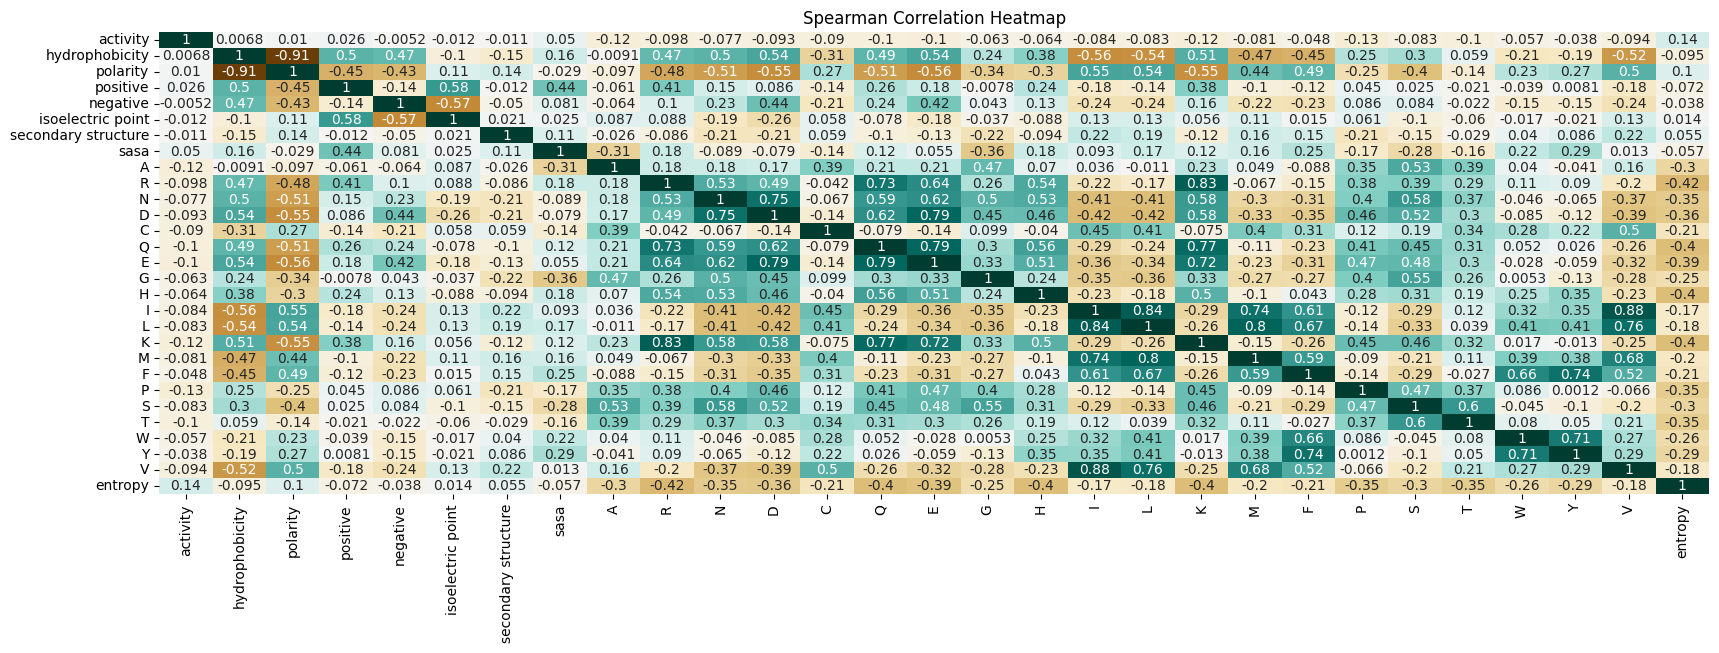

In [8]:
# Analyse the the pairwise correlation between all dataset variables and visualize
# them in a heatmap
plt.figure(figsize=(20,6))
sns.heatmap(corr, cmap='BrBG', center=0, annot=True, cbar=False)
plt.title('Spearman Correlation Heatmap')
plt.show()

Second, we analyse the correlation between each pair of features. 
Setting the treshold at 0.95, we decided to do not drop any of the features. In the case that we had found some features with a correlation higher than the threshold, we would have decided to eliminate one of them since we would assume that they were redundant and were explaining the same information.

**4. Building, training and validating the models**

While in every machine learning problem its a good rule of thumb to try a variety of algorithms, it can be especially beneficial in imbalanced datasets. Thus, we decided to try different alogirthms used in LBSs prediction:
- Random Forest
- XGBoost Classifier
- Support Vector Classifier

Regarding the validation step, since accuracy is not the best metric to use when evaluating imbalanced datasets, we decided to implement several metrics that can provide better insight:
- **Confusion matrix**: a table showing correct predictions and types of incorrect predictions.
- **Precision**: the number of true positives divided by all positive predictions. Also called Positive Predictive Value.
- **Recall**: the number of true positives divided by the number of positive values in the test data. Also called Sensitivity or True Positive Rate.
- **F1 Score**: the weighted average of precision and recall. 
- **ROC curve**: the ROC curve evaluates the effectiveness of classification problems at various threshold settings proving the model's capacity for class distinction and, thus, its capacity for precise prediction. The ROC curve is plotted with the true positive ratio (TPR) against the false positive ratio (FPR) where TPR is on the y-axis and FPR is on the x-axis. 


**DEAL WITH IMBALANCED DATA** 

Regarding the balancing techniques, we also tried different approaches:
- Undersampling the majority class to have the same samples as the minority one.
- SMOTE algorithm to have the same samples in the minority class as in the majority one. 
- Undersampling the majority class to have two times the samples of the minority class and then apply SMOTE algorithm to populate the minority class in order to have the same samples as the majority one.

- **Undersampling**

In [9]:
# Concatenate the training data back together
training_data = pd.concat([x_train, y_train], axis=1)
training_data.head()

# check initial counts
training_data.activity.value_counts()

activity
0    48746
1     2914
Name: count, dtype: int64

In [10]:
# Separate minority and majority classes
Binding = training_data[training_data.activity==1]
Non_binding = training_data[training_data.activity==0]

# undersample majority
non_binding_undersampled = resample(Non_binding,
                          replace=True, # sample with replacement
                          n_samples= 2914, # minority*2 (i.e.5828) or minority (i.e. 2914). We leave the code with 2914 since the best model was achive with only undersampling the majority class.
                          random_state=42)

# Combine majority and upsampled minority
under_sampled = pd.concat([non_binding_undersampled, Binding])

# Check new class counts
under_sampled.activity.value_counts()

activity
0    2914
1    2914
Name: count, dtype: int64

In [11]:
# Separate the training data again into responsive and explanatory variables
x_train = under_sampled.drop('activity', axis=1)
y_train = under_sampled.activity

In [12]:
y_train.value_counts()

activity
0    2914
1    2914
Name: count, dtype: int64

- **SMOTE**

In [9]:
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)

In [ ]:
y_train.value_counts()

- **Random forest classifier**

Precision: 0.3488372093023256
Recall: 0.20442930153321975
F1 score: 0.2577873254564984


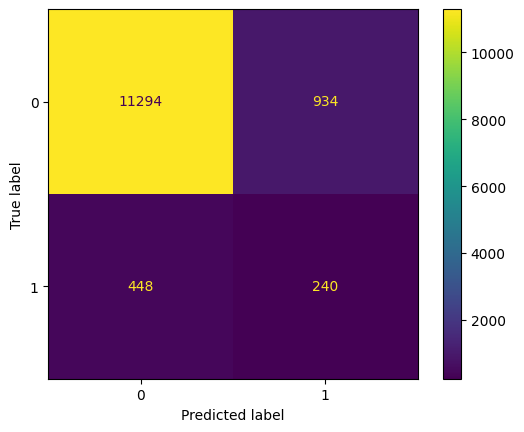

In [13]:
# Define the model
RandForest_model = RandomForestClassifier(n_estimators = 100,criterion='gini', 
                                          min_samples_split = 2, max_features = 2, random_state = 42)
# Train the model
RandForest_model.fit(x_train,y_train)
  
# Validate the model
yhat = (RandForest_model.predict_proba(x_valid)[:,1]>=0.70).astype(int)
randfor_prec = precision_score(yhat,y_valid)
print("Precision: %s" %(randfor_prec))
randfor_rec = recall_score(yhat,y_valid)
print("Recall: %s" %(randfor_rec))
randfor_f1score = f1_score(yhat,y_valid)
print("F1 score: %s" %(randfor_f1score))

# Visualize the confusion matrix
cm = confusion_matrix(y_valid, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=RandForest_model.classes_)
disp.plot()
plt.show()

AUC: 0.6362275676868188


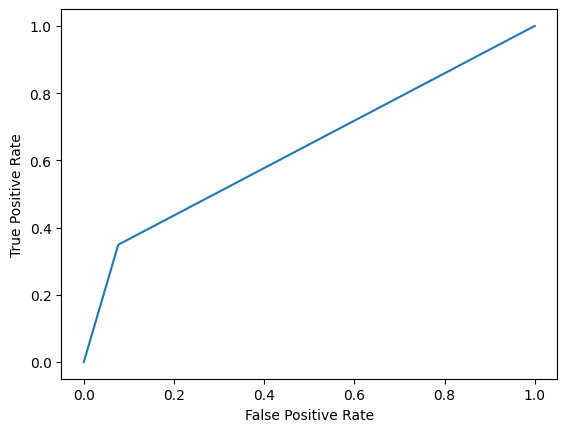

In [14]:
# Plot the ROC curve
y_pred_proba_randfor = (RandForest_model.predict_proba(x_valid)[:,1] >= 0.7).astype(int)
fpr_randfor, tpr_randfor, _ = roc_curve(y_valid, y_pred_proba_randfor)
randfor_auc = roc_auc_score(y_valid, y_pred_proba_randfor)
print("AUC: %s" %(randfor_auc))

plt.plot(fpr_randfor,tpr_randfor)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- **XGBOOST classifier**

In this case we first have to deal with the imbalanced dataset. Therefore, we must solve this and convert the unbalanced dataset to balanced. In order to do so, we will use **SMOTE (Synthetic Minority Oversampling Technique)**, which is an algorithm to populate the minority class with synthetic obervations.

Precision: 0.46511627906976744
Recall: 0.14618547281863864
F1 score: 0.22245394508168229


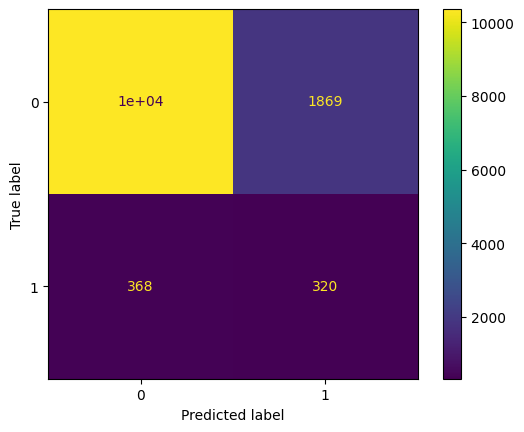

In [15]:
# Define the model
XGBoost_model = XGBClassifier(objective="binary:logistic", random_state=42)

# Train the model
XGBoost_model.fit(x_train,y_train)

# Validate the model
yhat = (XGBoost_model.predict_proba(x_valid)[:,1]>=0.70).astype(int)
xgboost_prec = precision_score(yhat,y_valid)
print("Precision: %s" %(xgboost_prec))
xgboost_rec = recall_score(yhat,y_valid)
print("Recall: %s" %(xgboost_rec))
xgboost_f1score = f1_score(yhat,y_valid)
print("F1 score: %s" %(xgboost_f1score))


# Visualize the confusion matrix
cm = confusion_matrix(y_valid, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=XGBoost_model.classes_)
disp.plot()
plt.show()

AUC: 0.6561351758449917


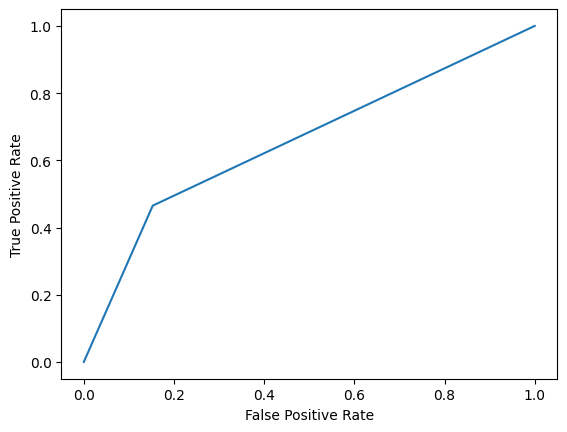

In [16]:
# Plot the ROC curve
y_pred_proba_xgboost = (XGBoost_model.predict_proba(x_valid)[:,1] >= 0.7).astype(int)
fpr_xgboost, tpr_xgboost, _ = roc_curve(y_valid, y_pred_proba_xgboost)
xgboost_auc = roc_auc_score(y_valid, y_pred_proba_xgboost)
print("AUC: %s" %(xgboost_auc))

plt.plot(fpr_xgboost,tpr_xgboost)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- **Support vector classifier**

Precision: 0.4273255813953488
Recall: 0.18455743879472694
F1 score: 0.2577816747040772


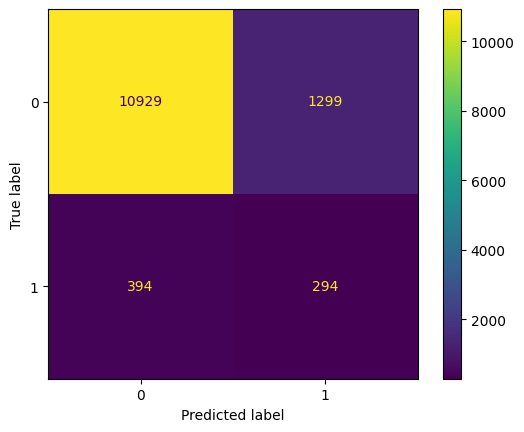

In [17]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

# Define the model
SVC_model = SVC(probability=True)

# Train the model
SVC_model.fit(x_train_scaled,y_train)

# Validate the model
yhat = (SVC_model.predict_proba(x_valid_scaled)[:,1]>=0.70).astype(int)
svc_prec = precision_score(yhat,y_valid)
print("Precision: %s" %(svc_prec))
svc_rec = recall_score(yhat,y_valid)
print("Recall: %s" %(svc_rec))
svc_f1score = f1_score(yhat,y_valid)
print("F1 score: %s" %(svc_f1score))


# Visualize the confusion matrix
cm = confusion_matrix(y_valid, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=SVC_model.classes_)
disp.plot()
plt.show()

AUC: 0.6605469908939453


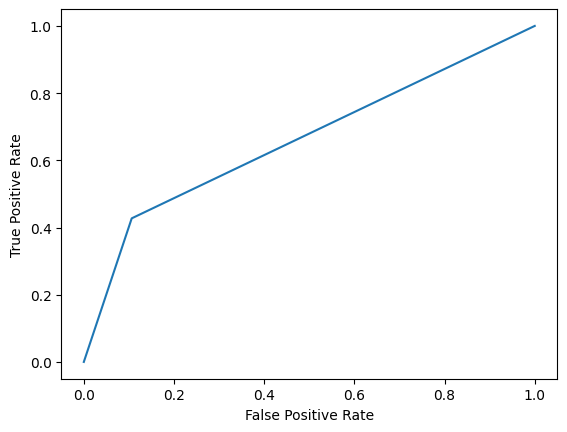

In [18]:
# Plot the ROC curve
y_pred_proba_SVC = (SVC_model.predict_proba(x_valid_scaled)[:,1] >= 0.7).astype(int)
fpr_SVC, tpr_SVC, _ = roc_curve(y_valid, y_pred_proba_SVC)
SVC_auc = roc_auc_score(y_valid, y_pred_proba_SVC)
print("AUC: %s" %(SVC_auc))

plt.plot(fpr_SVC,tpr_SVC)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**5. Comparison of all performed ML models using undersampling and SMOTE**

In [19]:
# Comparison table of all Machine Learning classification models
results = {'Classifier': ['Random Forest', 'XGBoost', 'Support Vector'], 
           'Precision': [randfor_prec, xgboost_prec, svc_prec],
           'Recall': [randfor_rec, xgboost_rec,svc_rec],
           'F1 score': [randfor_f1score, xgboost_f1score, svc_f1score], 
           'AUROC': [randfor_auc, xgboost_auc, SVC_auc]}
df = pd.DataFrame(data=results)
df.head()

,Classifier,Precision,Recall,F1 score,AUROC
0,Random Forest,0.348837,0.204429,0.257787,0.636228
1,XGBoost,0.465116,0.146185,0.222454,0.656135
2,Support Vector,0.427326,0.184557,0.257782,0.660547


**6. Test the selected model**

In [20]:
yhat_test = RandForest_model.predict(x_test)
randfor_prec_test = precision_score(yhat_test,y_test)
print("Precision: %s" %(randfor_prec_test))

Precision: 0.6589595375722543


**Get the importances of the features**

<Axes: xlabel='Features'>

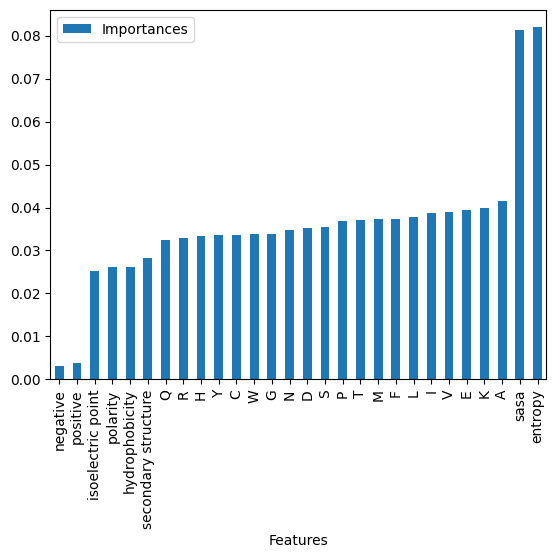

In [21]:
importances = RandForest_model.feature_importances_

# Create a dataframe for visualization
df = pd.DataFrame({"Features":pd.DataFrame(x_train).columns, "Importances": importances})
df.set_index('Features', inplace = True)


# Sorting in ascending order to better visualization
df = df.sort_values('Importances')

# Plot the feature importances in bars
df.plot.bar()

**7. Save the selected model**

In [22]:
joblib_file1 = "joblib_RandForest_undersampling_model.pkl"  
joblib.dump(RandForest_model, joblib_file1)

['joblib_RandForest_undersampling_model.pkl']